In [1]:
import torch
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

from base import SelfAttn, W_svm_solver

In [2]:
# if cross_attn is True, then we use cross attention
# if cross_attn is False, then we use self attention (i.e. set z_i = x_{i,atten_idx})
cross_attn = True
attn_idx = 0
lr = 0.1

n = 6
T = 8
d = 10

ITN = 2000
RUN = 100
eps = torch.finfo(torch.double).eps

# True: W-parametrization
# False: (K, Q)-parametrization
univariates = [True, False]

sfx_probs = np.zeros((2, RUN, ITN))
W_fro_corrs = np.zeros((2, RUN, ITN))
W_nuc_corrs = np.zeros((2, RUN, ITN))


def data_generator(seed):
    generator = torch.Generator()
    generator.manual_seed(seed)
    v = torch.randn((d), generator=generator)
    v /= torch.norm(v)
    Y = 2 * torch.ones(n) * (torch.randn(n, generator=generator)>0) - 1
    X = torch.randn((n, T, d), generator=generator)
    X /= torch.norm(X, dim=-1, keepdim=True)
    Z = torch.randn((n, d), generator=generator)
    Z /= torch.norm(Z, dim=-1, keepdim=True)
    best_ids = ((X @ v) * Y.view(-1,1)).argmax(dim=-1)
    return X, Y, Z, v, best_ids

In [3]:
for run in range(RUN):
    # data generation
    seed = run
    X, Y, Z, v, best_ids = data_generator(seed)
    X, Y, Z, v = X.double(), Y.double(), Z.double(), v.double()
    for i in range(len(univariates)):
        univariate = univariates[i]
        model = SelfAttn(d, univariate=univariate).double()
        model.v.data = v
        if univariate:
            params = [model.W.weight]
        else:
            params = [model.query.weight, model.key.weight]
        optimizer = torch.optim.SGD(params, lr=lr)
        Ws = np.zeros((ITN, d, d))
        for it in range(ITN):
            optimizer.zero_grad()
            out = model(X, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn).view(-1)
            loss = torch.log(1+torch.exp(-Y*out))
            loss = loss.mean()
            if univariate is False:
                loss += eps * (model.key.weight.norm()**2+model.query.weight.norm()**2)
            loss.backward()
            if univariate:
                model.W.weight.grad /= (model.W.weight.grad.norm()+eps)
            else:
                model.key.weight.grad /= ((model.key.weight.grad.norm())+eps)
                model.query.weight.grad /= ((model.query.weight.grad.norm())+eps)
            optimizer.step()
            W = model.W.weight.detach().T if univariate else model.query.weight.T.mm(model.key.weight).T.detach()
            W = W.numpy()
            sfx_out = model.sfx_out.detach().max(dim=-1)
            sfx_probs[i, run, it], ids = sfx_out[0].mean(), sfx_out[1]
            Ws[it] = W
        sol_fro = W_svm_solver(X, ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=True)
        sol_fro /= npl.norm(sol_fro)
        sol_nuc = W_svm_solver(X, ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=False)
        sol_nuc /= npl.norm(sol_nuc)
        for it in range(ITN):
            W = Ws[it]/npl.norm(Ws[it])
            W_fro_corrs[i, run, it] = sol_fro.reshape(-1).dot(W.reshape(-1))
            W_nuc_corrs[i, run, it] = sol_nuc.reshape(-1).dot(W.reshape(-1))
        # print(f'run{run}: loss={loss.detach()}, corres={W_fro_corrs[i, run, -1], W_nuc_corrs[i, run, -1]}')

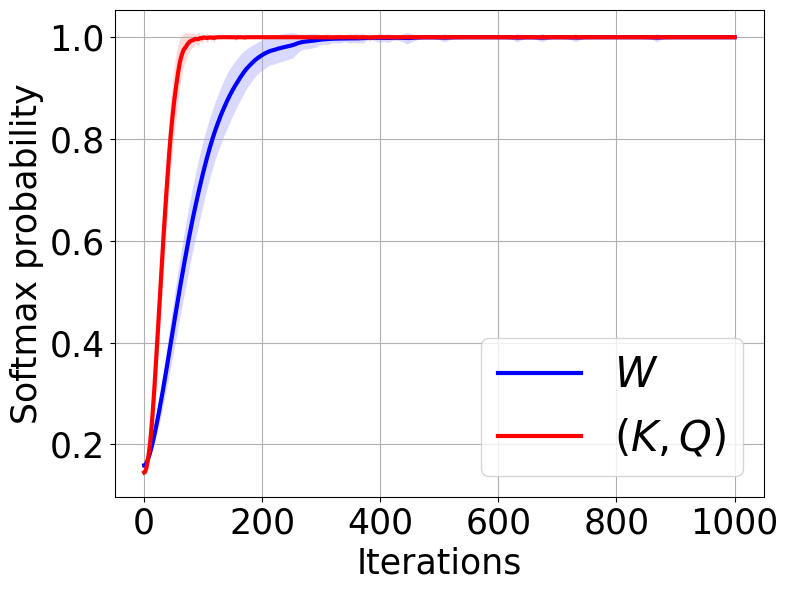

In [4]:
plt.figure(figsize=(8,6))
THRED = 1001

plt.plot(sfx_probs[0].mean(0)[:THRED], color='b', linewidth=3, label=r'$W$')
mean, std = sfx_probs[0].mean(0)[:THRED], sfx_probs[0].std(0)[:THRED]
plt.fill_between(range(THRED), mean-std, mean+std, color='b', alpha=0.15, linewidth=0)

plt.plot(sfx_probs[1].mean(0)[:THRED], color='r', linewidth=3, label=r'$(K,Q)$')
mean, std = sfx_probs[1].mean(0)[:THRED], sfx_probs[1].std(0)[:THRED]
plt.fill_between(range(THRED), mean-std, mean+std, color='r', alpha=0.15, linewidth=0)

plt.legend(fontsize=30)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Softmax probability', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()

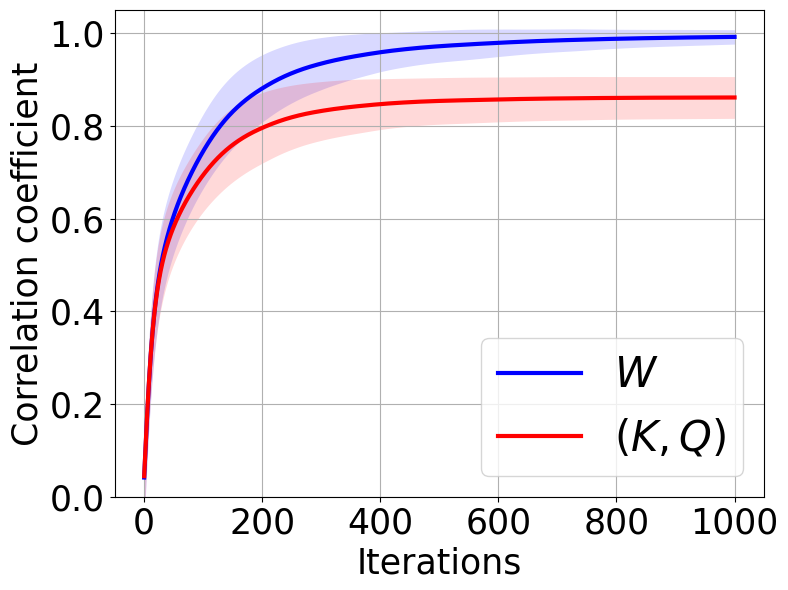

In [5]:
# set idx=0 for W-parametrization
# set idx=1 for (K, Q)-parametrization
idx = 0

plt.figure(figsize=(8,6))
THRED = 1001

plt.plot(W_fro_corrs[idx].mean(0)[:THRED], color='b', linewidth=3, label=r'$W$')
mean, std = W_fro_corrs[idx].mean(0)[:THRED], W_fro_corrs[idx].std(0)[:THRED]
plt.fill_between(range(THRED), mean-std, mean+std, color='b', alpha=0.15, linewidth=0)

plt.plot(W_nuc_corrs[idx].mean(0)[:THRED], color='r', linewidth=3, label=r'$(K,Q)$')
mean, std = W_nuc_corrs[idx].mean(0)[:THRED], W_nuc_corrs[idx].std(0)[:THRED]
plt.fill_between(range(THRED), mean-std, mean+std, color='r', alpha=0.15, linewidth=0)

plt.legend(fontsize=30)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Correlation coefficient', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0, 1.05])
plt.grid()
plt.tight_layout()
plt.show()